# notebooks.binary_patterns_applications

We solve the simple pattern completion problem (introduced in https://arxiv.org/abs/quant-ph/9807053) and some of its variants with the proposed architectures.

In [3]:
import math

In [10]:
def encode_bitstring(bitstring: str, qr: QuantumRegister,
                     cr: ClassicalRegister, inverse=False) -> QuantumCircuit:
    """
    Create a quantum circuit for constructing the quantum superposition of the bitstring.

    Args:
        bitstring (str): Binary string to encode in the quantum circuit.
        qr (QuantumRegister): Quantum register to use for the circuit.
        cr (ClassicalRegister): Classical register to use for the circuit.
        inverse (bool): If True, creates the inverse of the encoding circuit.

    Returns:
        QuantumCircuit: Quantum circuit with the encoded bitstring.

    Raises:
        AssertionError: If the length of the bitstring is less than 2.
    """
    n = math.ceil(math.log2(len(bitstring))) + 1
    assert n > 2, "the length of bitstring must be at least 2"
    qc = QuantumCircuit(qr, cr)
    desired_vector = np.array([ 0.0 for i in range(2**n) ])
    amplitude = np.sqrt(1.0/2**(n-1))
    for i, b in enumerate(bitstring):
        pos = i * 2
        if b == "1":
            pos += 1
        desired_vector[pos] = amplitude
    desired_vector = desired_vector / np.linalg.norm(desired_vector)
    if not inverse:
        qc.initialize(desired_vector, qr)
        qc.barrier(qr)
    else:
        desired_vector_real = np.real(desired_vector)
        qc.initialize(desired_vector_real,qr)
        for i in range(n):
            qc.measure(qr[i], cr[i])
    return qc

## QuAM-based architecture

Firs, we solve the pattern completion problem with the QuAM-based architecture.

In [6]:
from functions.patterns_utilities import *
from functions.QUAM import *
from qiskit.visualization import plot_histogram

In [7]:
patterns = generate_patterns(4,4)
patterns

['0101', '1000', '0011', '1010']

0.50 |0011> + 0.50 |0101> + 0.50 |1000> + 0.50 |1010>


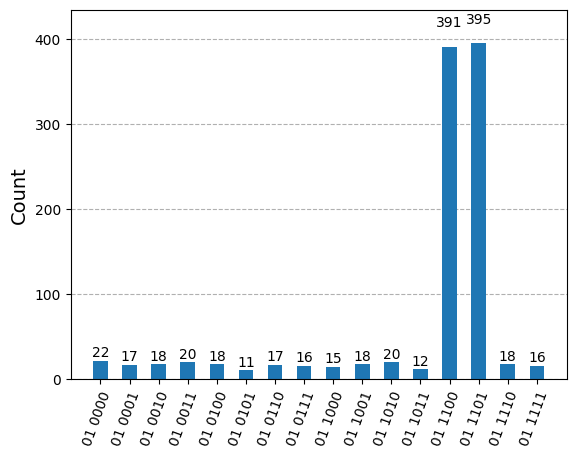

In [8]:
state, data = QuAM(patterns, search="110?")
print(state)
plot_histogram(data)

Now we solve an associated similarity problem: given a string `search` not in the QuAM extract from the QuAM the most similar pattern. There are two options

**Option 1**
- Generate boolean expression `expression = similarity(patterns,search)`
- Build oracle `PhaseOracle(expression)`
- Grover search with given oracle

**Option 2**
- Encode state `|similarity(patterns, search)>`
- Run standard Grover to extended database `|patterns>, |similarity(patterns, search)>`

We will focus on Option 1.

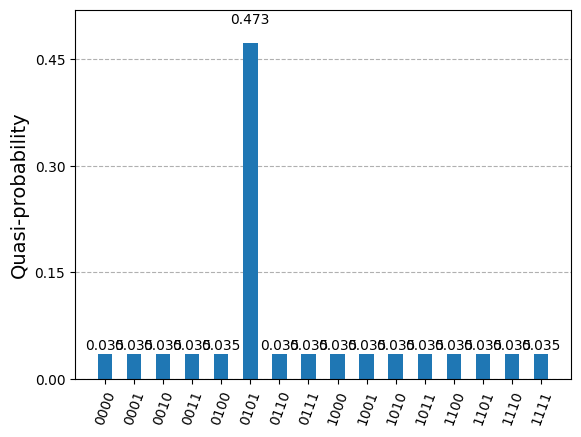

In [14]:
search = "0001"
result = grover_search(qc=None, x=None, c=None, output=None, xc=None, cc=None, R=None, s=search, patterns=patterns, problem="similarity")
display(plot_histogram(result.circuit_results[0]))

## Circuit-based architecture

We repeat the previous steps with the Circuit-based architecture. Notice that the pattern completion problem is a special case of the pattern search problem, so we focus on this one.

In [15]:
# Get corresponding quantum circuits (direct)
n = math.ceil(math.log2(len(patterns))) + 1
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
qc_1 = encode_bitstring(patterns[0], qr, cr)
qc_2 = encode_bitstring(patterns[1], qr, cr)
qc_3 = encode_bitstring(patterns[2], qr, cr)
qc_4 = encode_bitstring(patterns[3], qr, cr)
circs = {patterns[0]: qc_1, patterns[1]: qc_2, patterns[2]: qc_3, patterns[3]: qc_4}

In [16]:
# Get corresponding quantum circuits (inverse)
inv_qc_1 = encode_bitstring(patterns[0], qr, cr, inverse=True)
inv_qc_2 = encode_bitstring(patterns[1], qr, cr, inverse=True)
inv_qc_3 = encode_bitstring(patterns[2], qr, cr, inverse=True)
inv_qc_4 = encode_bitstring(patterns[3], qr, cr, inverse=True)
inv_circs = {patterns[0]: inv_qc_1, patterns[1]: inv_qc_2, patterns[2]: inv_qc_3, patterns[3]: inv_qc_4}

In [17]:
shots = 1000
combined_circs = {}
count = {}
most_similar, most_similar_score = "", -1.0

for other_key in inv_circs:
    if other_key == search:
        continue
    combined_circs[other_key] = circs[other_key].compose(inv_circs[other_key])
    backend = Aer.get_backend("qasm_simulator")
    t_qc = transpile(combined_circs[other_key], backend=backend)
    job = backend.run(t_qc)
    st = job.result().get_counts(combined_circs[other_key])
    if "0"*n in st:
        sim_score = st["0"*n]/shots
    else:
        sim_score = 0.0

    print("Similarity score of",search,"and",other_key,"is",sim_score)
    if most_similar_score < sim_score:
        most_similar, most_similar_score = other_key, sim_score

print(search,"is most similar to", most_similar)

Similarity score of 0001 and 0101 is 0.266
Similarity score of 0001 and 1000 is 0.0
Similarity score of 0001 and 0011 is 0.246
Similarity score of 0001 and 1010 is 0.0
0001 is most similar to 0101
